In [1]:
# early stopping criteria
PATIENCE = 20
MIN_DELTA = 1e-1 # 1e-6

# learning rate
LR = 4e-3
DEVICE = 'cuda'


In [2]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [3]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../src/ to the sys path to access the coarsegrainer package
sys.path.append(pwd + '/../src/')

In [4]:
pwd

'/home/nima/__work/Coarse_graining/coarse_graining_code_2024_02/experiments'

In [5]:
# import time
# import collections

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
# import torch.nn.functional as F

# import openmm as omm
from openmm import app, unit


### import the coarse-graining module
import coarsegrainer as cg
from coarsegrainer.minimizer import EnergyMinimizer, CGMinimizer, GNNMinimizer, AnnealingLR
from coarsegrainer.energy import Energy, EnergyModule, LJ_potential, quadratic_potential 
from coarsegrainer.plotting import plot_line_3D, plot_graph

### protein folding module
import proteinfolding as pf

from experimentlogger import ExperimentLogger

V = lambda x: x.detach().cpu().numpy()

# Loading protein

In [6]:
# pdb_id = '2WXC' # '2JOF' # '5AWL'
pdb_id = '2JOF'

pdb_dir = '../data/pdb/'
os.makedirs(pdb_dir, exist_ok=True) 

pdb_file = os.path.join(pdb_dir, pdb_id+'.pdb')

# check if pdb file exists, if not download it
if not os.path.isfile(pdb_file):
    pdb_file = pf.download_pdb_file(pdb_id, dir = pdb_dir)
    
prot = pf.Protein(pdb_file)


In [7]:
pf.pdb_3d_view(pdb_file, width=400, height=300)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
pdb = app.PDBFile(pdb_file)
modeller = app.Modeller(pdb.topology, pdb.positions)
forcefield = app.ForceField("amber14-all.xml", "amber14/tip3pfb.xml")
modeller.addHydrogens(forcefield)
#self.modeller.deleteWater()
# modeller.addSolvent(forcefield, model="tip3p", padding=.05 * unit.nanometer)
system = forcefield.createSystem(modeller.topology)#, nonbondedMethod=PME, constraints=HBonds)


In [9]:
system.getNumParticles(), system.getNumForces()

(284, 5)

In [10]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = prot.node_positions.detach().numpy()*10 # 10x to go from nm to angstrom

pdb_orig_file = os.path.join(pdb_dir, f'orig-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_orig_file , 'w'))

pf.pdb_3d_view(pdb_orig_file, width=400, height=300)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
# p_.addModel(pf.get_file_text(pdb_file), 'pdb')
# p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'


# Unfolding protein

In [12]:
unfolder = pf.ProteinFolderOMM(pdb_file, temperature=1000)

In [13]:
pos = unfolder.run(10)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,-26939.917040899163,948.173716273995


2000,-26284.75749118603,968.8871237712657
Epoch 1/10, Energy: 536.95, Time: 0.24 s
3000,-25367.654509618646,1000.3434727681357
4000,-26023.747455671197,1001.8650001317498
Epoch 2/10, Energy: 1710.88, Time: 0.22 s
5000,-25829.931071355706,1026.7477417290957
6000,-25976.331857755547,981.8640806483533
Epoch 3/10, Energy: 1204.61, Time: 0.21 s
7000,-24615.117174222833,1043.2209849479445
8000,-25299.18191154278,1041.7771742406287
Epoch 4/10, Energy: 3540.34, Time: 0.21 s
9000,-26223.19077117718,1048.4338256445997
10000,-24757.391593053704,1032.5115593741393
Epoch 5/10, Energy: 3825.63, Time: 0.22 s
11000,-26151.751655652886,1009.6723604516709
12000,-25263.228928640252,1019.538783140463
Epoch 6/10, Energy: 2960.67, Time: 0.21 s
13000,-25500.626684263116,1025.6903299787477
14000,-26074.759598806268,992.6222861539125
Epoch 7/10, Energy: 1404.01, Time: 0.22 s
15000,-26338.170835569268,999.4928267232813
16000,-25578.172456815606,979.233953509177
Epoch 8/10, Energy: 1529.96, Time: 0.21 s
17000,-2

In [14]:
0.22/2000

0.00011

In [15]:
unfolder.pdb_file

'../data/pdb/2JOF.pdb'

In [16]:
pdb_unfolded = unfolder.save_pdb()

Saving pdb file to ../data/pdb/fold_2JOF-T1000-steps20000.pdb


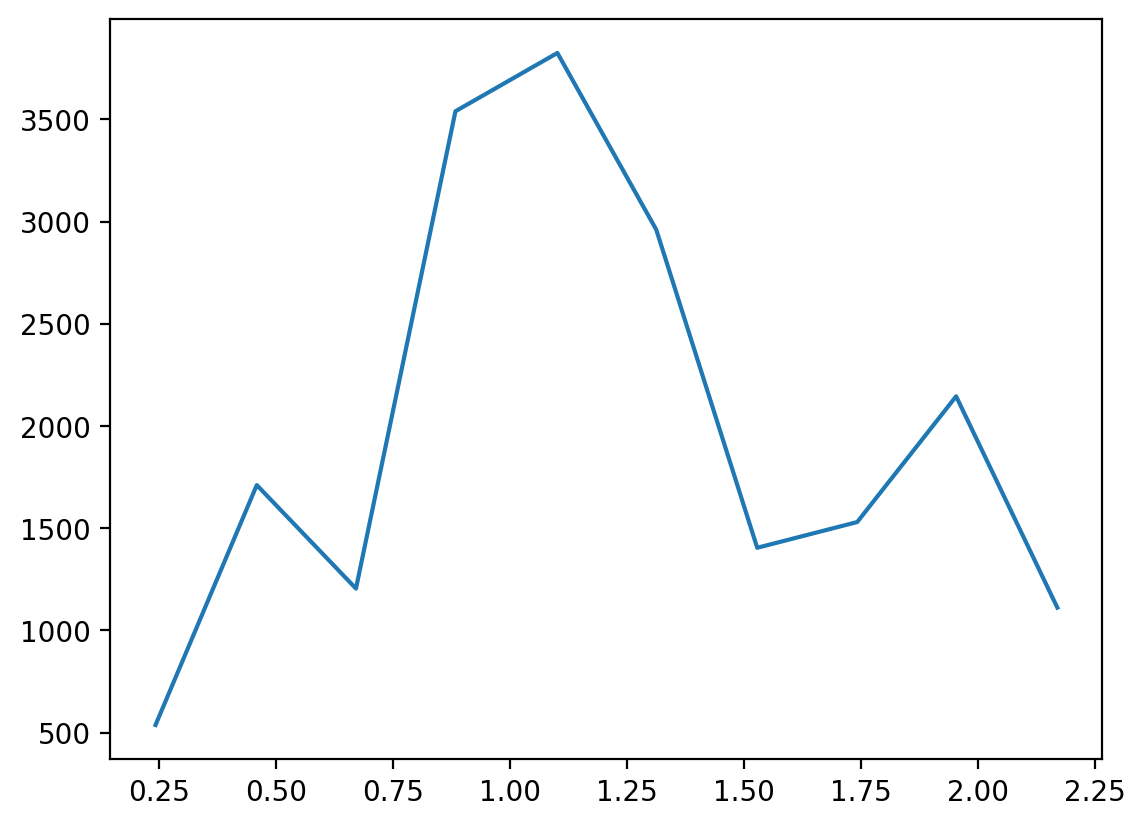

In [17]:
# plot energy vs time from history of the simulation
plt.plot(np.cumsum(unfolder.history['time']), unfolder.history['total_energy'])

In [17]:
pf.pdb_3d_view(pdb_unfolded)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [18]:
rmsd = pf.RMSD(pdb_orig_file, pdb_unfolded)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 4.706590975124258, 'CA': 3.3887085391608074, 'backbone': 3.190302205888113}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [21]:
refolder = pf.ProteinFolderOMM(pdb_unfolded, temperature=298)

In [22]:
pos = refolder.run(10)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,-92909.3835168269,407.013831358502
2000,-102019.00338987377,326.9938897819028
Epoch 1/10, Energy: -83448.39, Time: 0.43 s
3000,-104709.53473142651,304.2236765858787
4000,-106108.51529172924,297.154570378495
Epoch 2/10, Energy: -89232.53, Time: 0.21 s
5000,-106733.45541624096,303.9961277142292
6000,-106747.27119688061,294.57799256934555
Epoch 3/10, Energy: -90017.62, Time: 0.21 s
7000,-106660.98330930737,299.5225079152332
8000,-106536.68239072827,294.40386045983473
Epoch 4/10, Energy: -89816.92, Time: 0.21 s
9000,-106580.04348997143,297.41551438119046
10000,-106634.29315427807,298.5137528630303
Epoch 5/10, Energy: -89681.12, Time: 0.22 s
11000,-106868.965975323,286.3248575745873
12000,-106934.6349206355,298.0201951409849
Epoch 6/10, Energy: -90009.49, Time: 0.21 s
13000,-106834.40378049877,300.0584422391652
14000,-106424.09971860913,303.5310791030519
Epoch 7/10, Energy: -89185.98, Time: 0.21 s
15000,-106482.96325925854,294.7145

In [20]:
refolder.pdb_file

'../data/pdb/fold_2JOF-T1000-steps20000.pdb'

In [21]:
pdb_refolded = refolder.save_pdb()

Saving pdb file to ../data/pdb/fold_fold_2JOF-T1000-steps20000-T298-steps20000.pdb


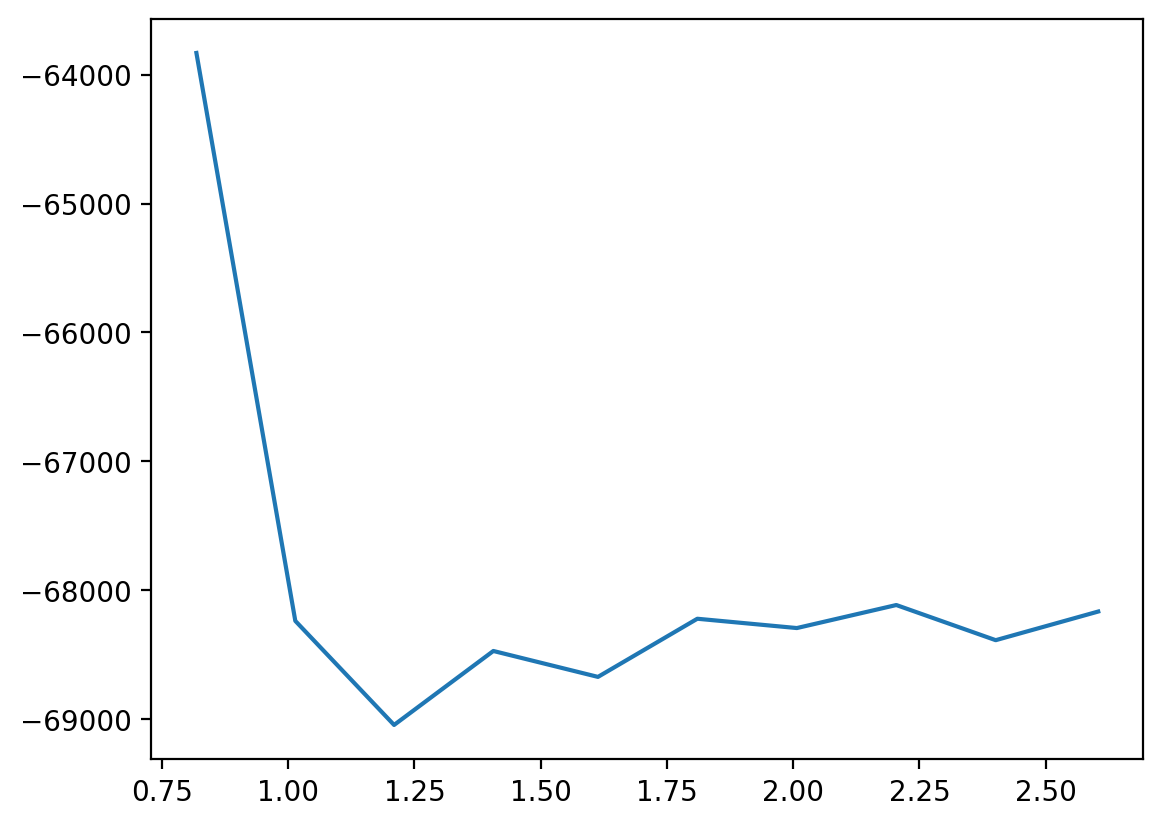

In [22]:
# plot energy vs time from history of the simulation
plt.plot(np.cumsum(refolder.history['time']), refolder.history['total_energy'])

In [23]:
pf.pdb_3d_view(pdb_refolded)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [30]:
rmsd = pf.RMSD(pdb_orig_file, pdb_refolded)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 5.531916148470496, 'CA': 4.07073217951377, 'backbone': 3.8533055845203577}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Energies

In [9]:
energy = pf.EnergyProtein(prot, device = DEVICE)
x = prot.node_positions.to(DEVICE)/10
pdb_energy = energy(x).item()
print(f'Energy of the protein: {pdb_energy:.2f}')
for f in["harmonic_bond_energy"
        ,"harmonic_bond_energy2"
        ,"harmonic_angle_energy"
        ,"torsion_angle_energy"
        ,"non_bonded_energy"]:
    print(f'{f}: {getattr(energy, f)(x).item():.4g}')

Energy of the protein: 7283117.50
harmonic_bond_energy: 6.056e+05
harmonic_bond_energy2: 6.056e+05
harmonic_angle_energy: 147.2
torsion_angle_energy: 992.3
non_bonded_energy: 6.676e+06


In [20]:
from openmm.app import PDBFile, ForceField, Modeller, Simulation, HBonds
from openmm import LangevinIntegrator, unit
from openmm.app import CutoffNonPeriodic

# Load PDB file
# pdb = PDBFile('your_pdb_file.pdb')
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

# Initialize modeller with the PDB topology and positions
modeller = Modeller(pdb.topology, pdb.positions)

# Create the system with a nonbonded cutoff and without periodic boundary conditions
system = forcefield.createSystem(modeller.topology,
                                 nonbondedMethod=CutoffNonPeriodic,
                                 nonbondedCutoff=1.0*unit.nanometers,
                                 constraints=HBonds)

# Define the integrator
integrator = LangevinIntegrator(298*unit.kelvin, 1/unit.picoseconds, 2*unit.femtoseconds)

# Set up the simulation
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)


In [21]:
# After running the simulation or initializing the context
state = simulation.context.getState(getEnergy=True)

# Print the total energy
total_energy = state.getPotentialEnergy()
print(f"Total Energy: {total_energy}")

# Access the system to iterate over forces
for i, force in enumerate(system.getForces()):
    # Force groups allow us to compute the energy contribution of each force separately
    force.setForceGroup(i)
    # Get the energy of the current force group
    group_state = simulation.context.getState(getEnergy=True, groups=2**i)
    group_energy = group_state.getPotentialEnergy()
    print(f"Energy from {force.__class__.__name__}: {group_energy}")


Total Energy: 1762.4341794550419 kJ/mol
Energy from HarmonicBondForce: 1762.4341794550419 kJ/mol
Energy from NonbondedForce: 0.0 kJ/mol
Energy from PeriodicTorsionForce: 0.0 kJ/mol
Energy from CMMotionRemover: 0.0 kJ/mol
Energy from HarmonicAngleForce: 0.0 kJ/mol


In [22]:
energy = pf.EnergyProtein(prot, device = DEVICE)
x = prot.node_positions.to(DEVICE)
pdb_energy = energy(x).item()
print(f'Energy of the protein: {pdb_energy:.2f}')
for f in["harmonic_bond_energy"
        ,"harmonic_angle_energy"
        ,"torsion_angle_energy"
        ,"torsion_angle_energy_old"
        ,"non_bonded_energy"]:
    print(f'{f}: {getattr(energy, f)(x).item():.4g}')

Energy of the protein: 99245.38
harmonic_bond_energy: 34.15
harmonic_angle_energy: 147.2
torsion_angle_energy: 992.3
torsion_angle_energy_old: 1740
non_bonded_energy: 9.807e+04


In [29]:
import openmm as omm
# get the ratio of harmonic bond energy from openMM and our energy class
# Access the system to iterate over forces
for i, force in enumerate(system.getForces()):
    # Force groups allow us to compute the energy contribution of each force separately
    force.setForceGroup(i)
    # Get the energy of the current force group
    group_state = simulation.context.getState(getEnergy=True, groups=2**i)
    group_energy = group_state.getPotentialEnergy()
    # if harmonic bond energy found, break
    if isinstance(force, omm.HarmonicBondForce):
        print(f"Energy from {force.__class__.__name__}: {group_energy}")
        break

print(f'harmonic_bond_energy ratio: {energy.harmonic_bond_energy(x).item()/group_energy.value_in_unit(unit.kilojoules_per_mole):.4g}')

Energy from HarmonicBondForce: 1762.4341794550419 kJ/mol
harmonic_bond_energy ratio: 0.01937


In [30]:
prot.harmonic_angle_data['k']/ np.pi * 180

tensor([38356.0859, 38356.0859, 23972.5527, 23972.5527, 23972.5527, 23972.5527,
        38356.0859, 33561.5781, 30205.4180, 23972.5527, 23972.5527, 30205.4180,
        23972.5527, 23972.5527, 23972.5527, 38356.0859, 23972.5527, 33561.5781,
        33561.5781, 23972.5527, 23972.5527, 38356.0859, 16780.7891, 16780.7891,
        16780.7891, 16780.7891, 30205.4180, 38356.0859, 23972.5527, 23972.5527,
        38356.0859, 33561.5781, 23972.5527, 23972.5527, 23972.5527, 30205.4180,
        23972.5527, 23972.5527, 23972.5527, 38356.0859, 23972.5527, 16780.7891,
        16780.7891, 16780.7891, 30205.4180, 38356.0859, 23972.5527, 23972.5527,
        38356.0859, 33561.5781, 30205.4180, 23972.5527, 23972.5527, 30205.4180,
        23972.5527, 23972.5527, 23972.5527, 38356.0859, 23972.5527, 33561.5781,
        33561.5781, 23972.5527, 23972.5527, 30205.4180, 23972.5527, 30205.4180,
        23972.5527, 30205.4180, 30205.4180, 23972.5527, 30205.4180, 23972.5527,
        23972.5527, 30205.4180, 33561.57

In [33]:
import time
def log_state(simulation, history, t0):
    dt = time.time() - t0
    state = simulation.context.getState(getEnergy=True, getPositions=True,)# getIntegratorParameters=True)
    E_kin = state.getKineticEnergy().value_in_unit(unit.kilojoule_per_mole)
    E_pot = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    history['total_energy'].append(E_kin + E_pot)
    history['potential_energy'].append(E_pot)
    history['kinetic_energy'].append(E_kin)
    # self.history['temperature'].append(state.getTemperature())
    history['time'].append(dt)
        
history = {'total_energy': [], 'potential_energy': [], 'kinetic_energy': [], 'temperature': [],'time': []}

In [34]:
epochs = 1000  
steps_per_epoch=2000

for i in range(epochs):
    # keep time for each step
    t0 = time.time()
    simulation.step(steps_per_epoch)
    # log to history 
    log_state(simulation, history, t0)
    print(f'Epoch {i+1}/{epochs}, Energy: {history["total_energy"][-1]:.2f}, Time: {history["time"][-1]:.2f} s')
    

Epoch 1/1000, Energy: 2829.16, Time: 0.19 s
Epoch 2/1000, Energy: 2648.97, Time: 0.04 s
Epoch 3/1000, Energy: 2729.74, Time: 0.04 s
Epoch 4/1000, Energy: 2773.63, Time: 0.04 s
Epoch 5/1000, Energy: 2813.50, Time: 0.04 s
Epoch 6/1000, Energy: 2718.27, Time: 0.04 s
Epoch 7/1000, Energy: 2844.45, Time: 0.04 s
Epoch 8/1000, Energy: 2805.73, Time: 0.04 s
Epoch 9/1000, Energy: 2683.54, Time: 0.04 s
Epoch 10/1000, Energy: 2776.82, Time: 0.04 s
Epoch 11/1000, Energy: 2747.79, Time: 0.04 s
Epoch 12/1000, Energy: 2811.88, Time: 0.04 s
Epoch 13/1000, Energy: 2674.12, Time: 0.04 s
Epoch 14/1000, Energy: 2870.66, Time: 0.04 s
Epoch 15/1000, Energy: 2797.55, Time: 0.04 s
Epoch 16/1000, Energy: 2771.08, Time: 0.04 s
Epoch 17/1000, Energy: 2884.32, Time: 0.04 s
Epoch 18/1000, Energy: 2746.63, Time: 0.04 s
Epoch 19/1000, Energy: 2755.95, Time: 0.04 s
Epoch 20/1000, Energy: 2759.74, Time: 0.04 s
Epoch 21/1000, Energy: 2693.20, Time: 0.04 s
Epoch 22/1000, Energy: 2750.15, Time: 0.04 s
Epoch 23/1000, Ener

KeyboardInterrupt: 

In [35]:
pos = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(modeller.topology, pos, open(f'test-{pdb_id}.pdb', 'w'))

In [36]:
pf.pdb_3d_view(f'test-{pdb_id}.pdb')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [37]:
# After running the simulation or initializing the context
state = simulation.context.getState(getEnergy=True)

# Print the total energy
total_energy = state.getPotentialEnergy()
print(f"Total Energy: {total_energy}")

# Access the system to iterate over forces
for i, force in enumerate(system.getForces()):
    # Force groups allow us to compute the energy contribution of each force separately
    force.setForceGroup(i)
    # Get the energy of the current force group
    group_state = simulation.context.getState(getEnergy=True, groups=2**i)
    group_energy = group_state.getPotentialEnergy()
    print(f"Energy from {force.__class__.__name__}: {group_energy}")


Total Energy: 1900.8222075551748 kJ/mol
Energy from HarmonicBondForce: 1900.8222075551748 kJ/mol
Energy from NonbondedForce: 0.0 kJ/mol
Energy from PeriodicTorsionForce: 0.0 kJ/mol
Energy from CMMotionRemover: 0.0 kJ/mol
Energy from HarmonicAngleForce: 0.0 kJ/mol


In [37]:
# list of node labels
prot.node_label

# dict of node features: ids, a, k
prot.harmonic_bond_data.keys()

k = 10
# for the first k nodes print the node label, id, atom type and spring constant with description
for i in range(k):
    print(f'Node {i}: {prot.node_label[i]}')
    print(f'  atom type: {prot.harmonic_bond_data["a"][i]:.3g}')
    print(f'  spring constant: {prot.harmonic_bond_data["k"][i]:.3g}')
    print('')

Node 0: N
  atom type: 0.152
  spring constant: 2.65e+05

Node 1: C
  atom type: 0.123
  spring constant: 4.77e+05

Node 2: C
  atom type: 0.153
  spring constant: 2.59e+05

Node 3: O
  atom type: 0.109
  spring constant: 2.85e+05

Node 4: C
  atom type: 0.147
  spring constant: 3.07e+05

Node 5: C
  atom type: 0.152
  spring constant: 2.65e+05

Node 6: O
  atom type: 0.109
  spring constant: 2.85e+05

Node 7: O
  atom type: 0.109
  spring constant: 2.85e+05

Node 8: H
  atom type: 0.125
  spring constant: 5.49e+05

Node 9: H
  atom type: 0.125
  spring constant: 5.49e+05



# Energy Minimization

In [34]:
positions = unfolder.positions[:len(prot.node_positions)]

In [35]:
p = positions[0]

In [36]:
pos_unfold = np.array([[i.x,i.y,i.z] for i in  positions.value_in_unit(unit.nanometer)])
pos_unfold = torch.tensor(pos_unfold, dtype=torch.float32)


In [37]:
energy = pf.EnergyProtein(prot, device = DEVICE)
pdb_energy = energy(prot.node_positions.to(DEVICE)).item()
# unfolded energy
pdb_unfolded_energy = energy(pos_unfold.to(DEVICE)).item()

f"{pdb_energy:.4g}, {pdb_unfolded_energy:.4g}"
# f"{pdb_energy:.4g}"

'9.925e+04, 1.035e+05'

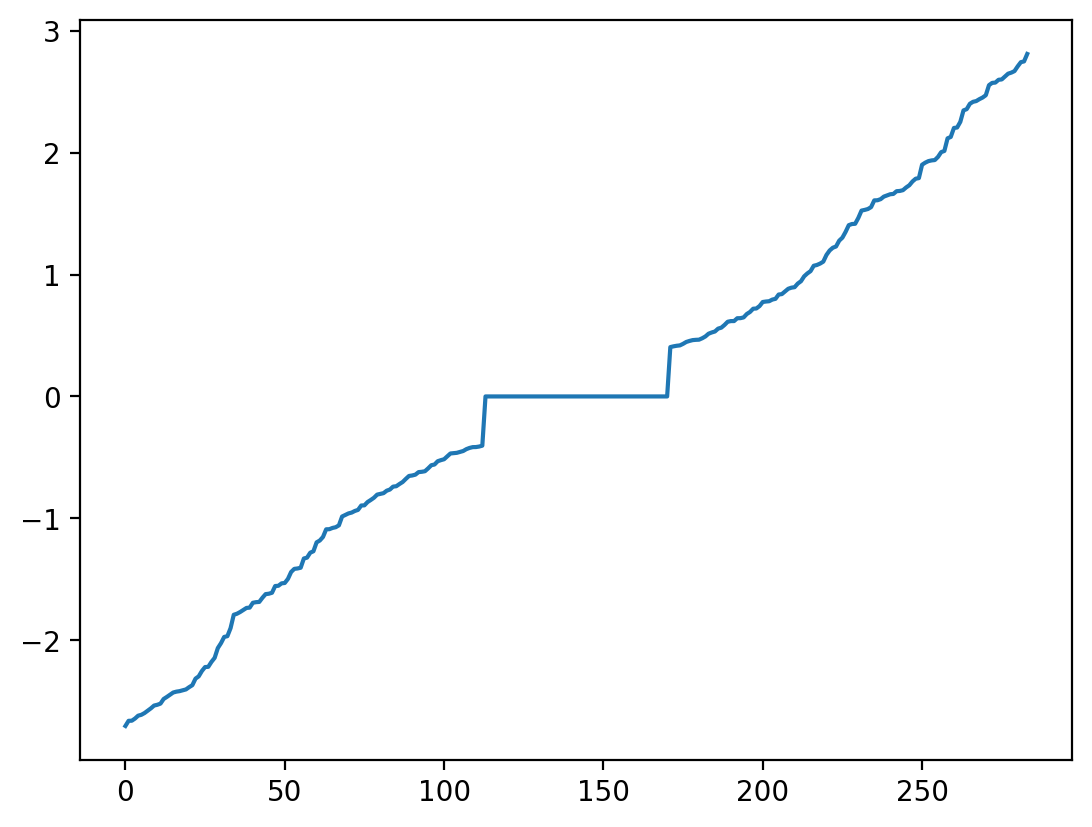

In [48]:
# spectrum of adjaceny matrix
p,v = torch.linalg.eigh(prot.adjacency_matrix)
plt.plot(p.detach().cpu().numpy())

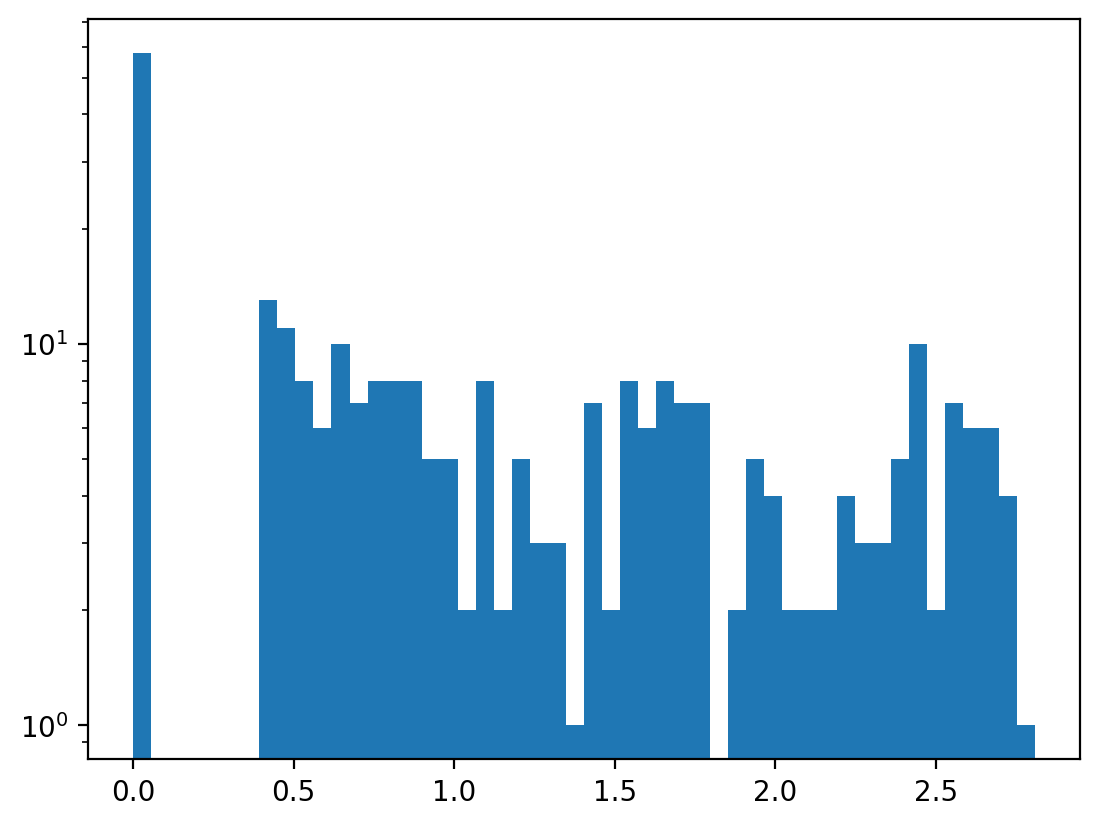

In [52]:
# spectrum of adjaceny matrix
p,v = torch.linalg.eigh(prot.adjacency_matrix)

h = plt.hist(np.abs(V(p)), bins=50, log = True)


## Starting from unfolded PDB positions

In [38]:
# define the initial position
# initial_pos = x = prot.node_positions.to(DEVICE)
initial_pos = x = pos_unfold.to(DEVICE)

energy_minimizer = EnergyMinimizer(energy, initial_pos, optimizer_type='Adam', lr=LR, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='protein_', patience=PATIENCE, min_delta=MIN_DELTA)

Using Adam optimizer
Log name: protein_
Logging to: ../results/logs/protein__n284_d3


In [39]:
# h = energy_minimizer.train(10000)

In [40]:
relax_counter = 3
for epoch in range(10):
    h = energy_minimizer.train(500)
    # also print the current lr
    if np.isnan(h['energy'][-1]):
        print('============Fail! nan')
        break
    c = energy_minimizer.early_stop.patience_counter
    print(f'epoch: {epoch}, energy: {h["energy"][-1]:.6g}, time: {np.sum(h["time"]):.2f} s, pat:{c},',end='\r')
    # annealer.step()
    # print(f'FG lr: {annealer.get_last_lr()[0]:.2e}', end = '\r')

    if energy_minimizer.early_stopping_triggered:
        relax_counter -= 1
        print(f'\nrelaxing {relax_counter}', end = '\n')
        if relax_counter < 0 :
            break

Early stopping at step 400 time: 7.41 s, pat:5,
epoch: 8, energy: 84745.9, time: 8.18 s, pat:20,
relaxing 2
Early stopping at step 480
epoch: 9, energy: 84750.7, time: 9.09 s, pat:20,
relaxing 1


In [41]:
t = energy_minimizer.history['time']
np.mean(t), np.std(t)

(0.036969102495084935, 0.007240908461208093)

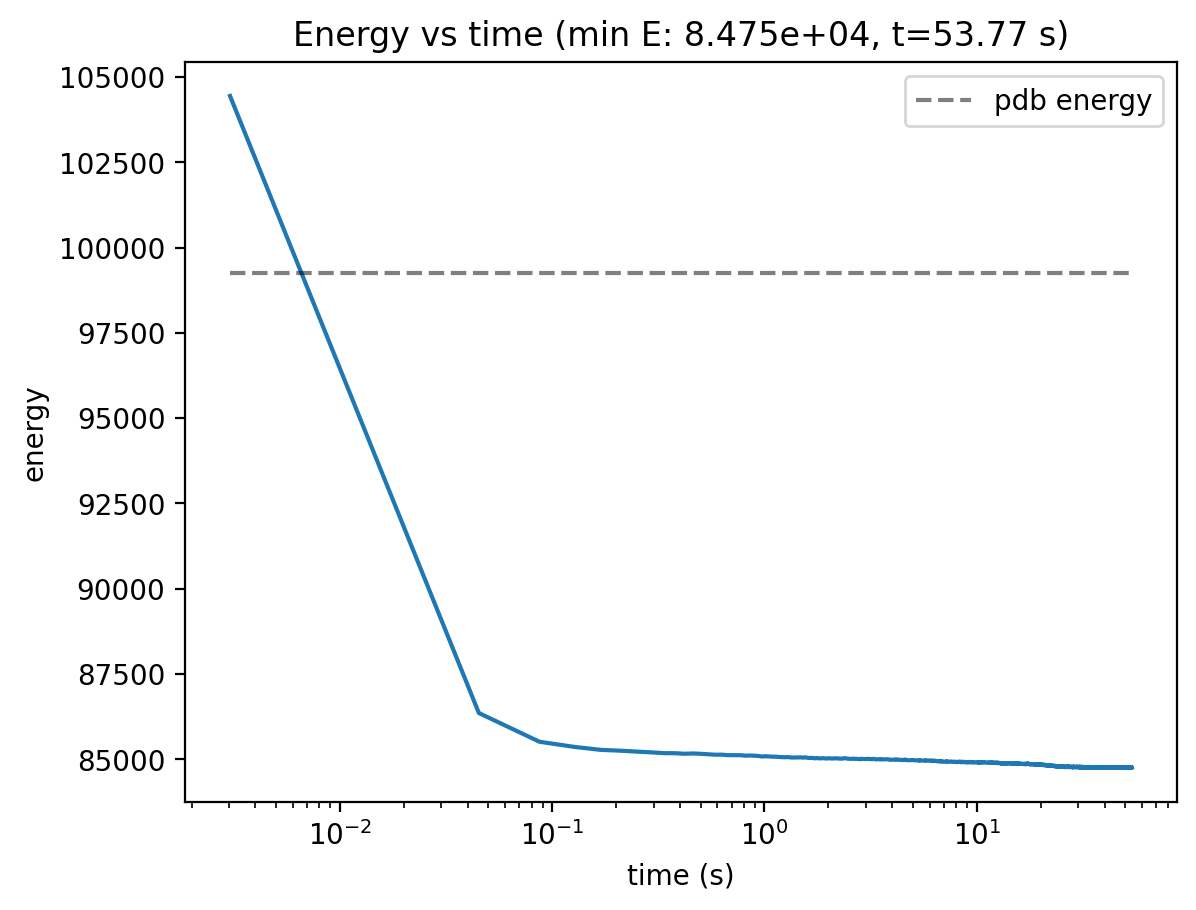

In [ ]:
energy_minimizer.plot_history()
plt.yscale('linear')

plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

plt.plot([h['time'][0],np.sum(h['time'])], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')

plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


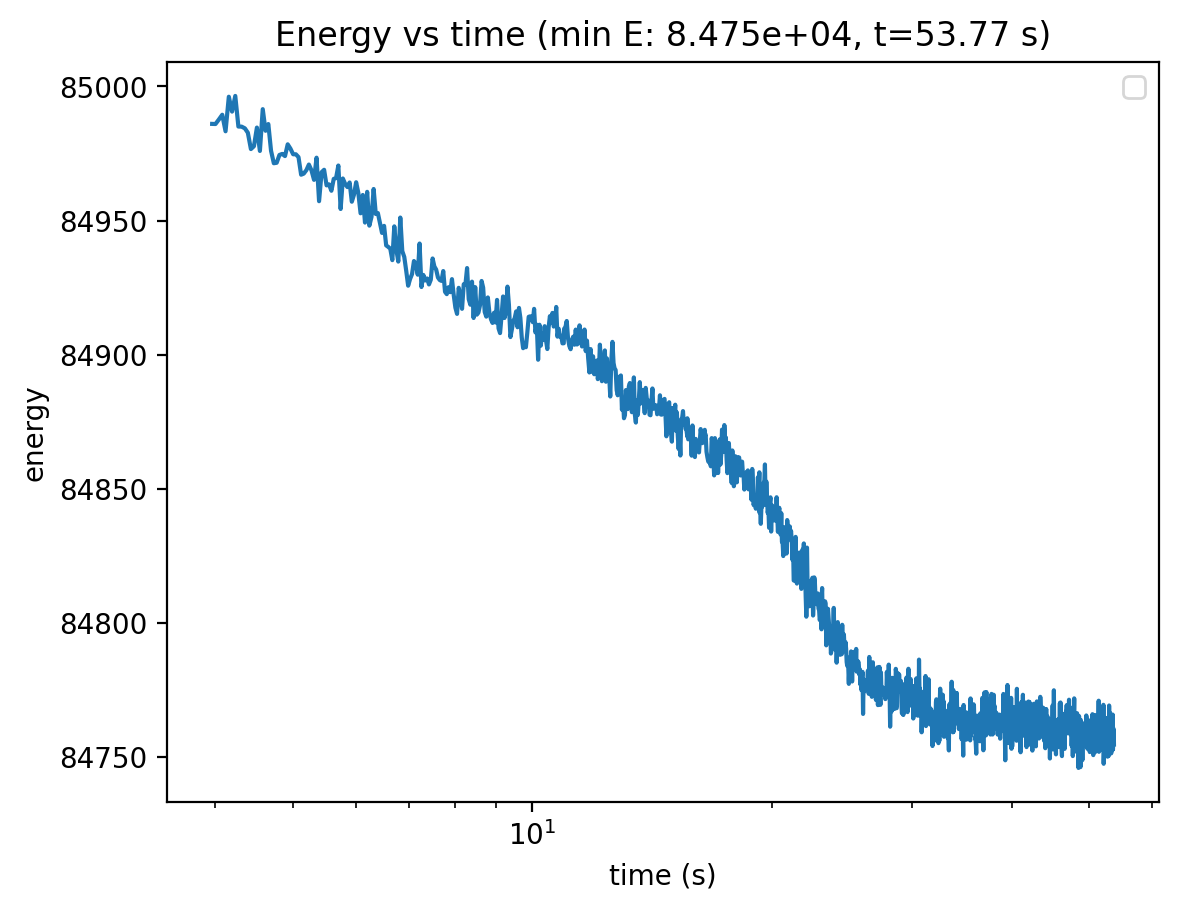

In [189]:
energy_minimizer.plot_history(100)
plt.yscale('linear')

plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

# plt.plot([h['time'][0],np.sum(h['time'])], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')

plt.legend()

In [215]:
N = 100
drop_rate = 40 #10
annealer = AnnealingLR(energy_minimizer.optimizer, 
                    lr_max=energy_minimizer.lr, 
                    lr_min=energy_minimizer.lr/drop_rate, 
                    epochs=N)


In [217]:
relax_counter = 10
for epoch in range(2*N):
    h = energy_minimizer.train(500)
    # also print the current lr
    if np.isnan(h['energy'][-1]):
        print('============Fail! nan')
        break
    c = energy_minimizer.early_stop.patience_counter
    print(f'epoch: {epoch}, energy: {h["energy"][-1]:.6g}, time: {np.sum(h["time"]):.2f} s, pat:{c},',end=' ')
    annealer.step()
    print(f'FG lr: {annealer.get_last_lr()[0]:.2e}', end = '\r')

    if energy_minimizer.early_stopping_triggered:
        relax_counter -= 1
        print(f'\nrelaxing {relax_counter}', end = '\n')
        if relax_counter < 0 :
            break

Early stopping at step 460, time: 33.91 s, pat:11, FG lr: 1.06e-03
epoch: 36, energy: 84708.8, time: 34.82 s, pat:20, FG lr: 1.02e-03
relaxing 9
Early stopping at step 440time: 37.64 s, pat:14, FG lr: 9.15e-044
epoch: 40, energy: 84705.4, time: 38.51 s, pat:20, FG lr: 8.81e-04
relaxing 8
Early stopping at step 420, time: 43.22 s, pat:10, FG lr: 7.33e-04
epoch: 46, energy: 84702.7, time: 44.05 s, pat:20, FG lr: 7.06e-04
relaxing 7
Early stopping at step 440, time: 48.68 s, pat:12, FG lr: 5.87e-04
epoch: 52, energy: 84701, time: 49.52 s, pat:20, FG lr: 5.66e-04
relaxing 6
Early stopping at step 420, time: 51.39 s, pat:11, FG lr: 5.26e-04
epoch: 55, energy: 84700.3, time: 52.20 s, pat:20, FG lr: 5.07e-04
relaxing 5
Early stopping at step 420, time: 53.14 s, pat:15, FG lr: 4.89e-04
epoch: 57, energy: 84700, time: 53.96 s, pat:20, FG lr: 4.71e-04
relaxing 4
Early stopping at step 460
epoch: 58, energy: 84699.9, time: 54.85 s, pat:20, FG lr: 4.54e-04
relaxing 3
Early stopping at step 480, ti

In [218]:
h = energy_minimizer.train(20000)

Early stopping at step 400


Text(0.5, 1.0, 'Energy vs time (min E: 8.468e+04, t=91.64 s)')

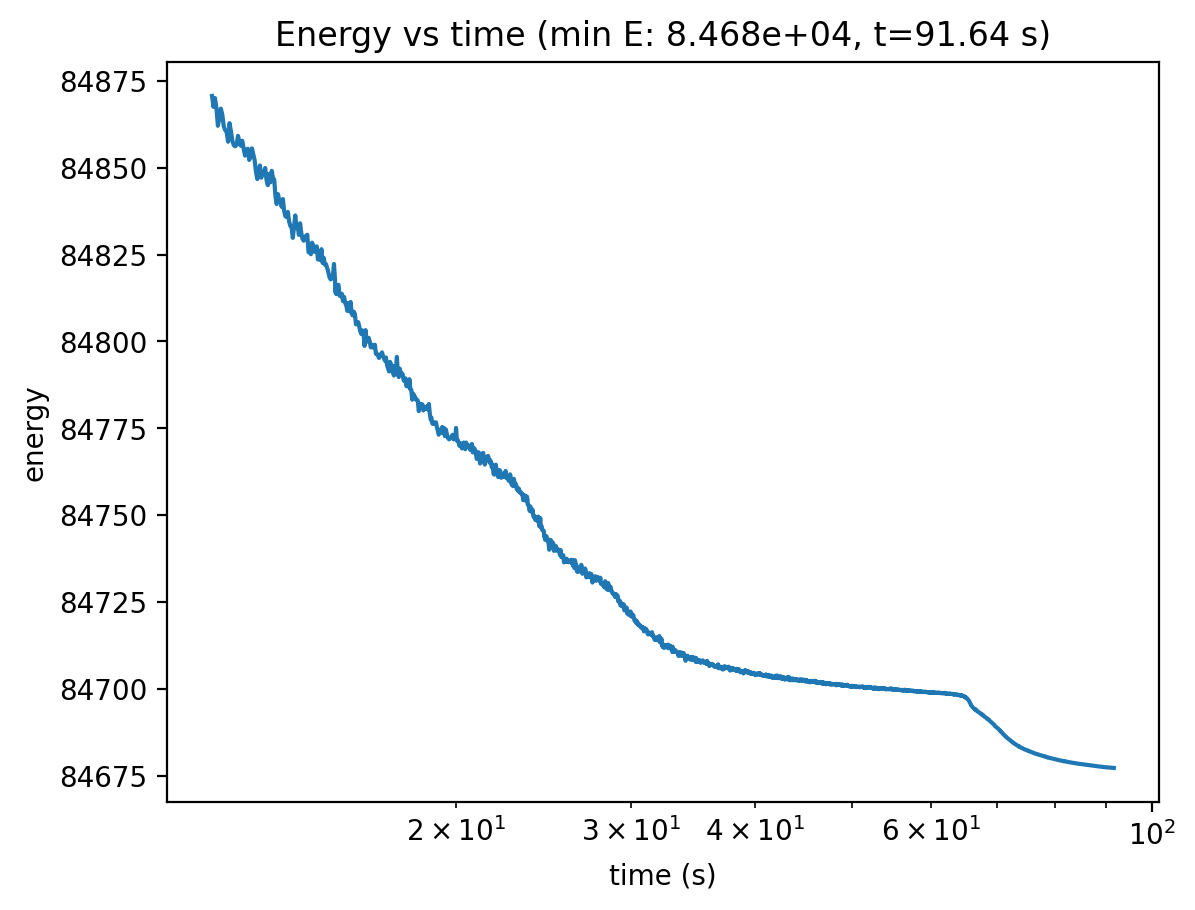

In [219]:
h = energy_minimizer.history
t = np.cumsum(h['time'])

k = 300

energy_minimizer.plot_history(k)


plt.yscale('linear')
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

# plt.plot(t[[k,-1]], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')


In [220]:
xf = energy_minimizer.get_x()
xf.std(dim=0)

tensor([0.3500, 0.5247, 0.8164], device='cuda:0', grad_fn=<StdBackward0>)

In [221]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = os.path.join(pdb_dir, f'./PDB_refine-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller_no_solvent.topology, new_positions, open(pdb_test_file , 'w'))

In [222]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [223]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 8.520239871445408, 'CA': 6.72085005474156, 'backbone': 6.557702895609035}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [208]:
rmsd = pf.RMSD(pdb_unfolded_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 3.363873875777111, 'CA': 2.7518393688643585, 'backbone': 2.6716279826191003}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# GNN

In [18]:
energy = pf.EnergyProtein(prot, device = DEVICE)
pdb_energy = energy(prot.node_positions.to(DEVICE)).item()
# unfolded energy
# pdb_unfolded_energy = energy(pos_unfold.to(DEVICE)).item()

# f"{pdb_energy:.4g}, {pdb_unfolded_energy:.4g}"
# f"{pdb_energy:.4g}"

In [53]:
from coarsegrainer.GNN import GNNReparam

# hidden dimension
h = 500 #100 #300
A = prot.adjacency_matrix.to(DEVICE) 
A += 0*energy.LJ_epsilon.to(DEVICE) + 0.2*torch.eye(len(A)).to(DEVICE)
# A = energy.LJ_epsilon.to(DEVICE)
# degree matrix
degs = torch.sum(A, dim=1)+1e-3
D_inv = torch.diag(1/degs)
# degree normalized adjacency matrix
# A =  D_inv**(1/2) @ A @ D_inv**(1/2) #+ 0.*torch.eye(len(A)).to(DEVICE)

n = len(A)
d = 3
init_scaling = .2 #.2 #6 #1.5
gnn_reparam = GNNReparam([h, h//1, h//1, d], A=A,
                        bias=True, 
                        initial_pos=prot.node_positions,
                        # activation=torch.nn.LeakyReLU() ,
                        activation=torch.nn.Tanh(), 
                        # output_init_sigma= init_scaling*init_radius, 
                        device=DEVICE, residual=True)


Fitting output: Step 100, loss: 2.1304e-06, time: 0.10 s, pat:3,
Finished fitting output: Step 127, loss: 1.32617e-07, time: 0.12 s, pat:20,


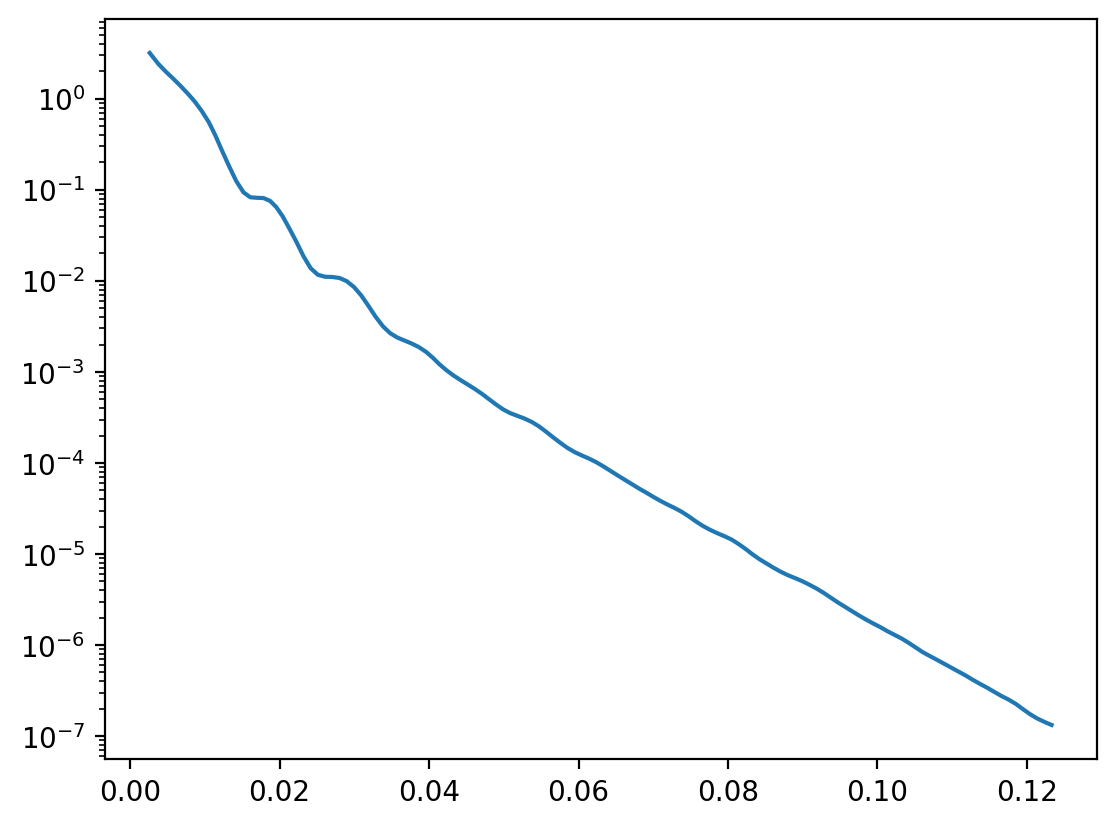

In [54]:
# plot fit history loss vs time 
plt.plot((gnn_reparam._fit_history['time']), gnn_reparam._fit_history['loss'])
plt.yscale('log')

In [55]:

new_positions = V(gnn_reparam())*10

pdb_test_file = os.path.join(pdb_dir, f'./test_gnn-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [56]:
p_ = pf.pdb_3d_view(pdb_test_file)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
# p_.setStyle({'stick': {}});
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [57]:
cg.earlystopping.EarlyStopping

coarsegrainer.earlystopping.EarlyStopping

In [58]:
prot.harmonic_bond_data.keys(), prot.non_bonded_data.keys(), prot.harmonic_angle_data.keys(), prot.torsion_angle_data.keys()

(dict_keys(['ids', 'a', 'k']),
 dict_keys(['charge', 'sigma', 'epsilon']),
 dict_keys(['ids', 't', 'k']),
 dict_keys(['ids', 'n', 't', 'k']))

In [59]:
for a in dir(prot):
    if '_data' in a:
        print(a)
        try: 
            for k, v in getattr(prot, a).items():
                print('\t',k, v.shape)
        except:
            pass

harmonic_angle_data
	 ids torch.Size([526, 3])
	 t torch.Size([526])
	 k torch.Size([526])
harmonic_bond_data
	 ids torch.Size([290, 2])
	 a torch.Size([290])
	 k torch.Size([290])
non_bonded_data
	 charge torch.Size([284])
	 sigma torch.Size([284])
	 epsilon torch.Size([284])
process_data_openmm
torsion_angle_data
	 ids torch.Size([922, 4])
	 n torch.Size([922])
	 t torch.Size([922])
	 k torch.Size([922])


## Node features

In [17]:
# import torch
from sklearn.preprocessing import MinMaxScaler

# Assuming atom_data is a list of dictionaries containing atom information
# atom_data = [{'type': 'H', 'charge': 0.1}, {'type': 'O', 'charge': -0.2}, ...]

# Step 1: Create a dictionary mapping each unique atom type to a unique integer
# atom_types = {atom['type'] for atom in atom_data}
atom_types = set(prot.node_label)
type_dict = {atom_type: i for i, atom_type in enumerate(atom_types)}

# Step 2: For each atom, create a one-hot encoded vector based on its type
atom_one_hot_encodings = torch.stack([torch.nn.functional.one_hot(torch.tensor(type_dict[a]), num_classes=len(atom_types)) for a in prot.node_label])


# concatenate all the atom features into a single tensor
# only the non_bonded_data are individual atoms, the rest are pairs of atoms or more
# so to define node attributes we will nly use the non_bonded_data

# node features
# note, the features are 1D tensors, so we need to add a dimension to make them 2D
node_features = torch.cat([val.unsqueeze(1) for key, val in prot.non_bonded_data.items()], dim=1)

# concatenate the one-hot encoded atom types with the other features
node_features = torch.cat([node_features, atom_one_hot_encodings], dim=1)

# scale the features to standardize them
scaler = MinMaxScaler()
node_features = torch.tensor(scaler.fit_transform(node_features), dtype=torch.float32)
node_features.shape

torch.Size([284, 7])

### define the GNNReaparam model

In [52]:
from coarsegrainer.GNN import GNN
from coarsegrainer.earlystopping import EarlyStopping

class GNNReparam(torch.nn.Module):
    def __init__(self, hidden_dims, cg=None, A=None, edgelist=None, num_cg=None, 
                latent_sigma='auto', initial_pos=None,
                bias=True, activation=torch.nn.ReLU(), output_init_sigma=1.0, node_attributes=None,
                residual=False, device='cpu'):
        """This is a class to implement the graph neural network reparameterization.
        The GNN will use the GCN layer to perform the graph convolution.
        It will take a set of hidden dimensions, including the input and output dimensions.
        The GNN will also choose whether to use the GCN or GCN_CG layer based on the inputs.

        Args:
            hidden_dims (list): The list of hidden dimensions. 
                The first element is the input dimension and 
                the last element is the output dimension. 
                It should have at least two elements.
            cg (object): The object containing the cg_modes and cg_eigenvalues.
            A (torch.Tensor, optional): The adjacency matrix. Defaults to None. 
                If given, edgelist is ignored.
            edgelist (torch.Tensor, optional): The edge list. Defaults to None.
                The edgelist is used to construct the a sparse adjacency matrix.
                If both or none of A and edgelist are given, an error is raised.
            num_cg (int): The number of cg_modes to use.
            initial_pos (torch.Tensor): The initial position of the particles.
            bias (bool, optional): Whether to include a bias term. 
                Defaults to True.
            activation (torch.nn.Module, optional): The activation function. 
                Defaults to torch.nn.ReLU().
            output_init_sigma (float, optional): The initial sigma for the output.
                Defaults to 1.0.
            node_attributes (torch.Tensor, optional): The node attributes.
                These are the features of the nodes and will be concatenated with the latent embedding.
                They will remain fixed during the reparameterization. 
                Defaults to None.
        """
        super().__init__()
        # self.to(device)
        self.hidden_dims = hidden_dims
        self.gnn = GNN(hidden_dims=hidden_dims,
                A=A,
                edgelist=edgelist,
                cg=cg,
                num_cg=num_cg,
                bias=bias,
                activation=activation,
                residual=residual)
        # we need the number of nodes to initialize the latent embedding
        # we can infer this from the cg_modes or A or edgelist
        self.get_num_nodes(cg, A, edgelist)
        # convert node attribs to torch tensor
        self.node_attributes = torch.tensor(node_attributes, dtype=torch.float32) if node_attributes is not None else None
        self.get_latent_embedding(latent_sigma)
        # in order to be able to rescale, we first need to make sure all weights are n the same device
        # self.to(self.gnn.layers[0].weight.device)
        self.to(device)
        # self.to(device)
        # self.node_attributes = self.node_attributes.to(device) if self.node_attributes is not None else None
        self.latent_embedding = self.latent_embedding.to(device)
        # self.rescale_output(output_init_sigma)
        # we fit the output to the initial position, if given
        if initial_pos is not None:
            self.initial_pos = initial_pos.to(device)
            x,self._fit_history = self.fit_output(self.initial_pos)
        else:
            self.initial_pos = None
            self._fit_history = None
        
    def get_num_nodes(self, cg, A, edgelist):
        if cg is not None:
            self.n = cg.cg_modes.shape[0]
        elif A is not None:
            self.n = A.shape[0]
        else:
            self.n = edgelist.max().int() + 1
        
    def get_latent_embedding(self, latent_sigma):
        """The latent embedding is the initial position of the particles. 
        The latent embedding is a learnable parameter of the model.
        The number of latent dimensions is the first hidden dimension of the GNN, 
        minus the number of node attributes.

        Args:
            latent_sigma (_type_): _description_
        """
        # get the latent embedding
        if latent_sigma == 'auto':
            latent_sigma = 1/np.sqrt(self.hidden_dims[0])
            # we use the std of the initial position to scale the initial position
            # self.latent_embedding = torch.nn.Parameter(self.gnn(self.initial_pos).std() * torch.randn(self.n, self.gnn.hidden_dims[0]))
        # we use the latent_sigma to scale the initial position
        # we also add the node attributes to the latent embedding, but we don't learn them
        if self.node_attributes is not None:
            self.latent_embedding0 = torch.nn.Parameter(latent_sigma * torch.randn(self.n, self.gnn.hidden_dims[0] - self.node_attributes.shape[1]))
            self.latent_embedding = torch.cat([self.latent_embedding0, self.node_attributes ], dim=1)
        else:        
            self.latent_embedding = torch.nn.Parameter(latent_sigma * torch.randn(self.n, self.gnn.hidden_dims[0]))
        
        
        
    def rescale_output(self, output_init_sigma):
        # rescale the output to match the std of the initial position
        init_gnn_std = self().std() 
        # rescale the weights of the last layer by the ratio of the stds
        self.gnn.layers[-1].weight.data *= output_init_sigma/init_gnn_std
        
    def forward(self):
        # compute the reparameterized x
        # assume x is of shape (n, in_features)
        return self.gnn(self.latent_embedding)
    
    # to fit the output positions to a given initial position, we use GD on MSE loss
    def fit_output(self, output_pos, lr=1e-3, n_steps=1000, patience=20, min_delta=1e-6):
        # fit the output to the given output_pos
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        early_stop = EarlyStopping(patience=patience, min_delta=min_delta)
        
        history = {'loss':[], 'time':[]}
        loss_fn = torch.nn.MSELoss()
        start = time.time()
        for i in range(n_steps):
            optimizer.zero_grad()
            output = self()
            loss = loss_fn(output, output_pos)
            loss.backward()
            optimizer.step()
            
            history['loss'].append(loss.item())
            history['time'].append(time.time()-start)
            if i % 100 == 0:
                # print(f"Fitting output: Step {i}, Loss: {loss.item()}", end='\r')
                print(f'Fitting output: Step {i}, loss: {loss.item():.6g}, time: {history["time"][-1]:.2f} s, pat:{early_stop.patience_counter},',end='\r')

            if early_stop(loss.item()):
                print(f'\nFinished fitting output: Step {i}, loss: {loss.item():.6g}, time: {history["time"][-1]:.2f} s, pat:{early_stop.patience_counter},')
                break
        return output, history

In [115]:
# from coarsegrainer.GNN import GNNReparam
import time
DEVICE = 'cuda'
# hidden dimension
h = 50 #300
A = prot.adjacency_matrix.to(DEVICE) 
A += 0*energy.LJ_epsilon.to(DEVICE) + 0.2*torch.eye(len(A)).to(DEVICE)
# A = energy.LJ_epsilon.to(DEVICE)
# degree matrix
degs = torch.sum(A, dim=1)+1e-3
D_inv = torch.diag(1/degs)
# degree normalized adjacency matrix
# A =  D_inv**(1/2) @ A @ D_inv**(1/2) #+ 0.*torch.eye(len(A)).to(DEVICE)

n = len(A)
d = 3
init_scaling = .2 #.2 #6 #1.5
gnn_reparam = GNNReparam([h, h//1, h//1, d], A=A,
                        bias=True, 
                        initial_pos=prot.node_positions.to(DEVICE),
                        # activation=torch.nn.LeakyReLU() ,
                        activation=torch.nn.Tanh(), 
                        node_attributes=node_features,
                        # output_init_sigma= init_scaling*init_radius, 
                        device=DEVICE, residual=True)


/tmp/ipykernel_465840/296723569.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.node_attributes = torch.tensor(node_attributes, dtype=torch.float32) if node_attributes is not None else None


In [116]:
gnn_reparam.latent_embedding

tensor([[ 0.0816, -0.0651,  0.0915,  ...,  0.0000,  1.0000,  0.0000],
        [-0.2564, -0.0974,  0.0719,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0247, -0.1049, -0.2523,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1882,  0.1039, -0.2036,  ...,  0.0000,  0.0000,  1.0000],
        [-0.1323,  0.0404,  0.0866,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.1458, -0.1527, -0.0026,  ...,  0.0000,  0.0000,  1.0000]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)

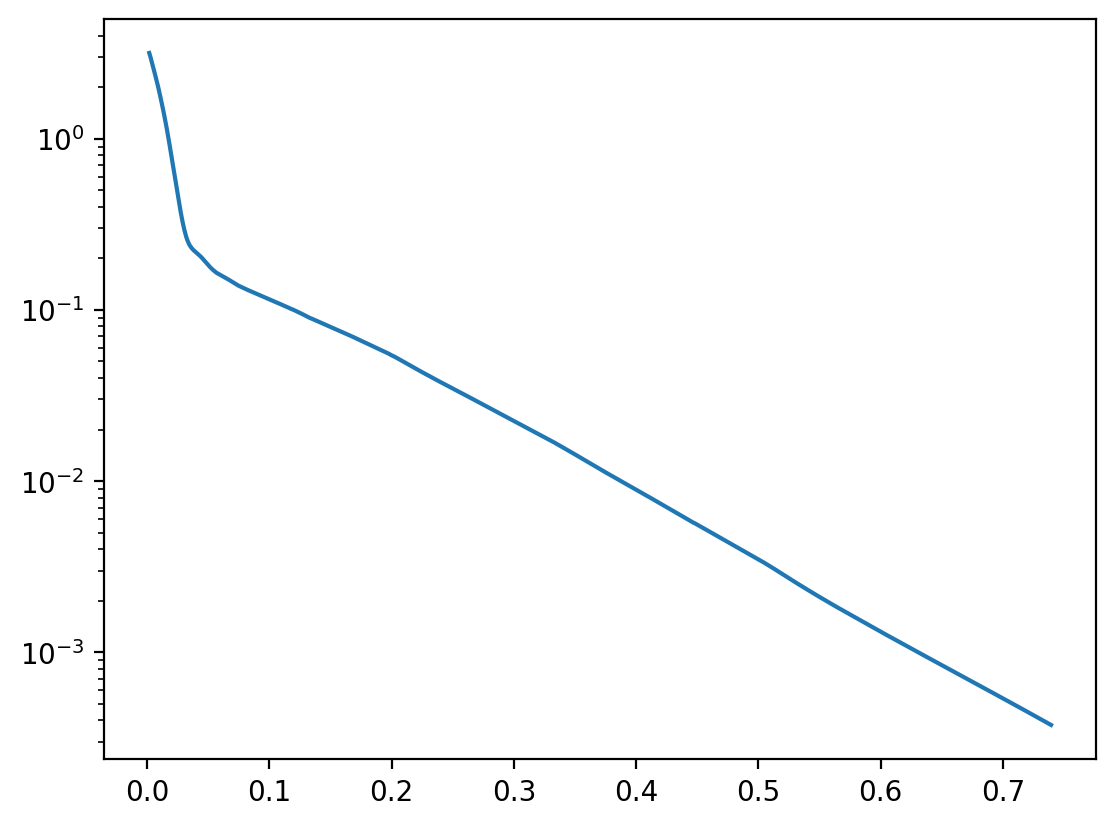

In [117]:
# plot fit history loss vs time 
plt.plot((gnn_reparam._fit_history['time']), gnn_reparam._fit_history['loss'])
plt.yscale('log')

In [118]:

new_positions = V(gnn_reparam())*10

pdb_test_file = os.path.join(pdb_dir, f'./test_gnn-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [119]:
p_ = pf.pdb_3d_view(pdb_test_file)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
# p_.setStyle({'stick': {}});
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

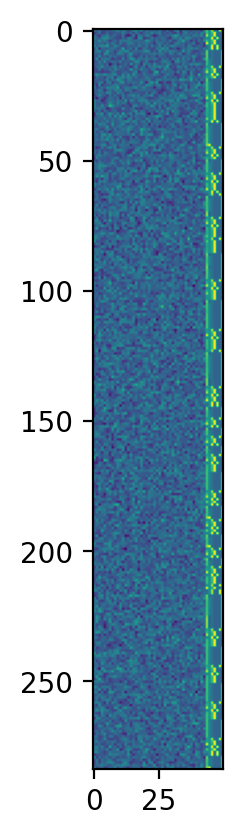

In [121]:
plt.imshow(V(gnn_reparam.latent_embedding))

## Energy minimization with GNN

In [60]:
x_target = prot.node_positions.to(DEVICE)
gnn_minimizer = GNNMinimizer(energy, x_target, gnn_reparam, optimizer_type='Adam',
    lr=LR*1e-1, lr_gnn=LR*2e-2,
    # lr=LR*5e-3, lr_gnn=LR*5e-3,
    # lr=4e-4, lr_gnn=1e-4,
    # lr=4e-3, lr_gnn=1e-4,
    # lr=1e-3, lr_gnn=1e-3,
    # lr=2*LR, lr_gnn=4e-3,
    clamp_grads=1e-2, log_step=20, log_pos_step=0, 
    log_dir='../results/logs', log_name=f'GNN_protein_{pdb_id}_',
    patience=PATIENCE, min_delta=MIN_DELTA*1e-0, 
    gnn_patience=PATIENCE, gnn_min_delta=MIN_DELTA*1e0)


Using Adam optimizer
Log name: GNN_protein_2JOF_
Logging to: ../results/logs/GNN_protein_2JOF__n284_d3
Using Adam optimizer


In [61]:
(gnn_reparam().std(), gnn_minimizer.get_x().std())

(tensor(1.3905, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(1.3905, device='cuda:0', grad_fn=<StdBackward0>))

In [62]:
N = 10
drop_rate = 50 #40 #10
annealer_gnn = AnnealingLR(gnn_minimizer.optimizer_gnn, 
                    lr_max=gnn_minimizer.lr_gnn, 
                    lr_min=gnn_minimizer.lr_gnn/drop_rate, 
                    epochs=N)

annealer_fg = AnnealingLR(gnn_minimizer.optimizer_fg, 
                    lr_max=gnn_minimizer.lr, 
                    lr_min=gnn_minimizer.lr/drop_rate, 
                    epochs=N)

In [63]:
# gnn_minimizer.min_delta /= 10

In [64]:
# annealer_fg.epochs = 200

In [65]:
# set the learning rate of optimizer_fg to 1e-3
# gnn_minimizer.optimizer_fg.param_groups[0]['lr'] = 1e-3  

In [66]:
relax_counter = 10
for epoch in range(10):#(2*N):
    h = gnn_minimizer.train(500)
    # also print the current lr
    
    c = gnn_minimizer.early_stop.patience_counter
    en = h["energy"][-1]
    if np.isnan(en):
        print('============Failed! Energy is nan============')
        break
    print(f'epoch: {epoch}, energy: {en:.6g}, time: {np.sum(h["time"]):.2f} s, pat:{c},',end=' ')
    
    if not gnn_minimizer.fine_grained:
        annealer_gnn.step()
        print(f'GNN lr: {annealer_gnn.get_last_lr()[0]:.2e}', end = '\r')
    else:
        annealer_fg.step()
        print(f'FG lr: {annealer_fg.get_last_lr()[0]:.2e}', end = '\r')
        
    if gnn_minimizer.early_stopping_triggered:
        
        print('\n')
        relax_counter -= 1
        print(f'\nrelaxing {relax_counter}', end = '\n')
        if relax_counter < 0 :
            break

In [67]:
t = gnn_minimizer.history['time']
np.mean(t), np.std(t)

(0.04561155319213867, 0.00885371927725616)

In [68]:
t0 = energy_minimizer.history['time']
np.mean(t0), np.std(t0)

(0.036969102495084935, 0.007240908461208093)

In [69]:
print(f'iter time GNN/GD: {np.mean(t)/np.mean(t0):.3g}')

iter time GNN/GD: 1.23


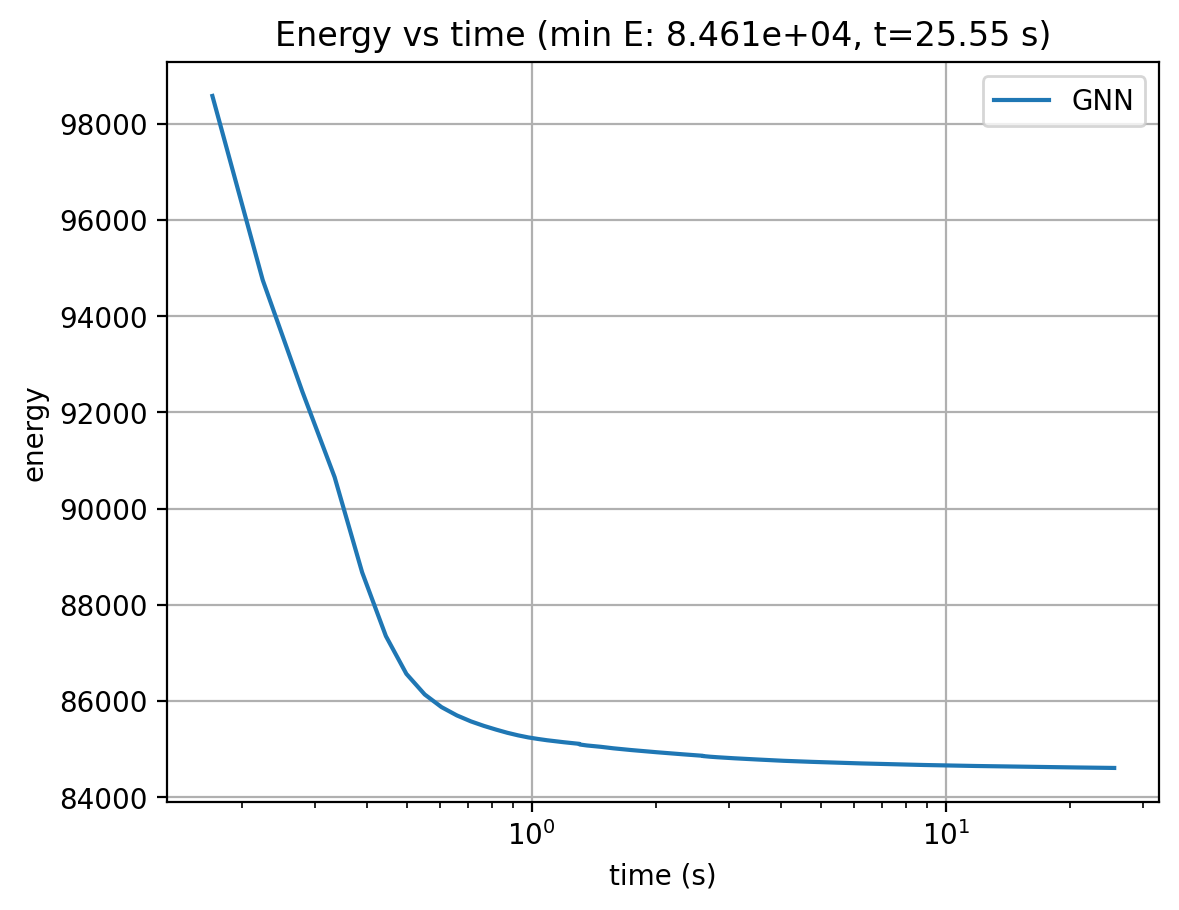

In [129]:
k = 3
gnn_minimizer.plot_history(start=k)
try:
    gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps+0)
except:
    pass
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

# energy_minimizer.plot_history(k)
# plt.ylim(h['energy'][-1]-10, h['energy'][k]+1.0)
plt.yscale('linear')
plt.grid(True)
plt.legend(['GNN', 'FG', 'GD'])

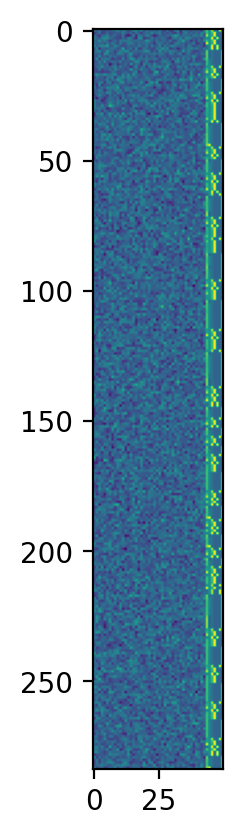

In [130]:
plt.imshow(V(gnn_reparam.latent_embedding))

### get X

In [135]:
xf = gnn_minimizer.get_x()
xf.std(dim=0)

tensor([0.4978, 0.4624, 0.3456], device='cuda:0', grad_fn=<StdBackward0>)

In [136]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = os.path.join(pdb_dir, f'./GNN-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [137]:
pf.pdb_3d_view(pdb_test_file)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### RMSD

In [138]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 0.7663642612356913, 'CA': 0.6004139558895111, 'backbone': 0.5779985367051585}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Symmetries of the Hessian and effective degrees of freedom